In [1]:
import time

import numpy as np
import pandas as pd
from treeop import Tree, str2tree
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
from netop import Network, compcostsmp
from tqdm import tqdm

In [2]:
df = pd.read_csv("simulation_mgr_table_extended.csv")

1. Filter non-bijective trees. They occur because sometimes two leaves have the same sequence simulated and the tree is not properly inferred by PhyML.

In [3]:
def is_correct(tree1_str, tree2_str):
    tree1_str, tree2_str = tree1_str.strip(";"), tree2_str.strip(";")
    tree_1, tree_2 = Tree(str2tree(tree1_str)), Tree(str2tree(tree2_str))
    return tree_1.root.cluster == tree_2.root.cluster and tree_1.root.subtree_size == tree_2.root.subtree_size

In [4]:
df['is_correct'] = df.apply(lambda row: is_correct(row['gene_tree_rooted'], row['displayed_tree']), axis=1)
df = df[df["is_correct"] == True]

2. Filter data in a way that for each ILS, region, n and r, there are 10 replicates of the simulation (ultimately there will be 50 datapoints/category)

In [5]:
grouped = df.groupby(['dna region', 'ILS', 'n', 'r'])
unfiltered_df = df
df = grouped.head(50)
df.reset_index(drop=True, inplace=True)
df.to_csv("preprocessed_simulation_data.csv")

4. Compute RF distance between displayed trees and inferred gene trees.

In [6]:
def compute_RF(tree1_str, tree2_str):
    tree1_str, tree2_str = tree1_str.strip(";"), tree2_str.strip(";")
    tree_1, tree_2 = Tree(str2tree(tree1_str)), Tree(str2tree(tree2_str))
    return tree_1.rfcost_norm(tree_2)

C:\Users\48604\AppData\Local\Temp\ipykernel_13816\3491665703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rf'] = df.apply(lambda row: compute_RF(row['displayed_tree'], row['gene_tree_rooted']), axis=1)


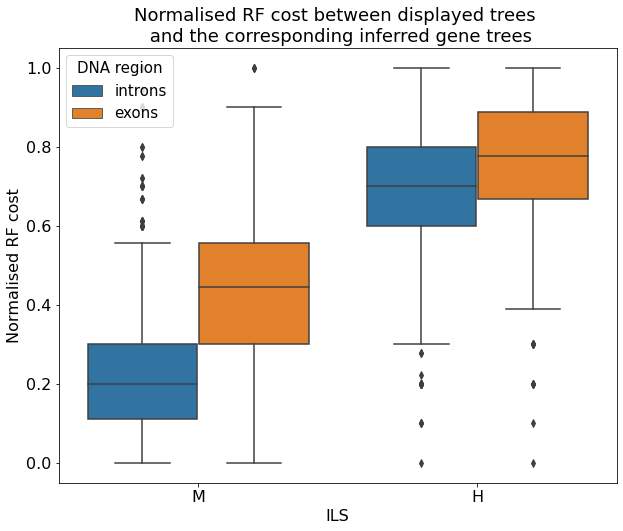

In [7]:
df['rf'] = df.apply(lambda row: compute_RF(row['displayed_tree'], row['gene_tree_rooted']), axis=1)
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x="ILS", hue="dna region", y="rf", ax=ax)
ax.set_title("Normalised RF cost between displayed trees \n and the corresponding inferred gene trees", fontsize=18)
ax.set_ylabel("Normalised RF cost", fontsize=16)
ax.set_xlabel("ILS", fontsize=16)
legend = ax.legend(title="DNA region", loc="upper left", prop={'size': 15})
legend.get_title().set_fontsize(15)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/rf_simulation_plot.pdf", format="pdf", bbox_inches="tight")

5. Compute dp_calls on simulated data


In [8]:
STAT_NAMES = ("dp_called", "branching_count", "max_depth", "best_depth", "time_in_seconds")
STAT_NAMES_FAST_ALGORITHM = (f"{stat_name}_fast_algo" for stat_name in STAT_NAMES)

def save_bnb_stats(network, tree, use_fast_algo):
    best_cost_bnb, stats = network.branch_and_bound(tree, return_stats=True, fast_DP=use_fast_algo)
    stats = [stats[name] for name in STAT_NAMES]
    return stats, best_cost_bnb

def save_naive_time(network, tree):
    min_cost = float("inf")
    start_time = time.time()
    for t in network.displayedtrees():
        min_cost = min(min_cost, compcostsmp(tree, Tree(str2tree(t)), "R"))
    end_time = time.time()
    naive_time = end_time - start_time
    return naive_time, min_cost

def save_stats(network_str, tree_str):
    network_str, tree_str = network_str.strip(";"), tree_str.strip(";")
    network, tree = Network(str2tree(network_str)), Tree(str2tree(tree_str))
    # stats_slow_algo, cost_slow_algo = save_bnb_stats(network, tree, use_fast_algo=False)
    stats_fast_algo, cost_fast_algo = save_bnb_stats(network, tree, use_fast_algo=True)
    time_naive, cost_naive = save_naive_time(network, tree)
    # full_stats = stats_slow_algo + [cost_slow_algo] + stats_fast_algo + [cost_fast_algo, time_naive, cost_naive]
    full_stats = stats_fast_algo + [cost_fast_algo, time_naive, cost_naive]
    return full_stats

# full_labels = [f"{stat}_slow_algo" for stat in STAT_NAMES] + ["cost_slow_algo"] + [f"{stat}_fast_algo" for stat in STAT_NAMES] + ["cost_fast_algo", "time_naive", "cost_naive"]
# full_labels = [f"{stat}_fast_algo" for stat in STAT_NAMES] + ["cost_fast_algo", "time_naive", "cost_naive"]
# tqdm.pandas()
# output_df = df.progress_apply(lambda row: pd.Series(save_stats(row['network'], row['gene_tree_rooted']), index=full_labels), axis=1)
# result_df = pd.concat([df, output_df], axis=1)
# result_df.to_csv("results_extended_priority_and_parcut.csv")

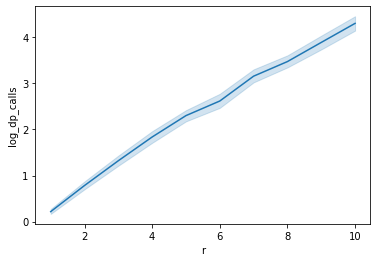

In [9]:
result_df = pd.read_csv("results_extended_priority_and_parcut.csv")
result_df["log_dp_calls"] = result_df.apply(lambda row: np.log2(row['dp_called_fast_algo']), axis=1)
sns.lineplot(x="r", y="log_dp_calls", data=result_df)
plt.show()

In [10]:
combined_model = LinearRegression()
combined_model.fit(result_df[["r"]], result_df["log_dp_calls"])
slope = combined_model.coef_[0]
intercept = combined_model.intercept_
print(f"Slope (Coefficient): {slope}")
print(f"Intercept: {intercept}")

Slope (Coefficient): 0.4455762215675577
Intercept: -0.06163037609170541


In [11]:
X = sm.add_constant(result_df[["r"]])
y = result_df["log_dp_calls"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           log_dp_calls   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     3877.
Date:                Sun, 15 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:08:07   Log-Likelihood:                -6724.3
No. Observations:                4000   AIC:                         1.345e+04
Df Residuals:                    3998   BIC:                         1.347e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0616      0.044     -1.388      0.1

In [12]:
print(model.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.492     
Dependent Variable: log_dp_calls     AIC:                13452.5785
Date:               2023-10-15 00:08 BIC:                13465.1666
No. Observations:   4000             Log-Likelihood:     -6724.3   
Df Model:           1                F-statistic:        3877.     
Df Residuals:       3998             Prob (F-statistic): 0.00      
R-squared:          0.492            Scale:              1.6901    
----------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
----------------------------------------------------------------------
const    -0.0616      0.0444    -1.3879    0.1652    -0.1487    0.0254
r         0.4456      0.0072    62.2626    0.0000     0.4315    0.4596
-------------------------------------------------------------------
Omnibus:              115.002       Durbin-Watson: 

In [13]:
def perform_regression(df, ILS_value, dna_region_value):
    subset = df[(df["ILS"] == ILS_value) & (df["dna region"] == dna_region_value)]

    if not subset.empty:
        X = subset[["r"]]
        y = subset["log_dp_calls"]

        model = LinearRegression()
        model.fit(X, y)

        result = {
            "ILS": ILS_value,
            "dna region": dna_region_value,
            "slope": model.coef_[0],
            "intercept": model.intercept_,
            "R-squared": model.score(X, y)
        }
        return X, y, model, result

# Compute linear regression for each combination
combinations = [("M", "introns"), ("M", "exons"), ("H", "introns"), ("H", "exons")]

results = []
results_parcut = []
for i, combo in enumerate(combinations):
    X, y, regression_model, result = perform_regression(result_df, combo[0], combo[1])
    results.append(result)

regression_df = pd.DataFrame(results)
print(regression_df)

  ILS dna region     slope  intercept  R-squared
0   M    introns  0.321297  -0.038760   0.398161
1   M      exons  0.431376   0.032143   0.573930
2   H    introns  0.506360  -0.047313   0.563070
3   H      exons  0.523272  -0.192591   0.552053


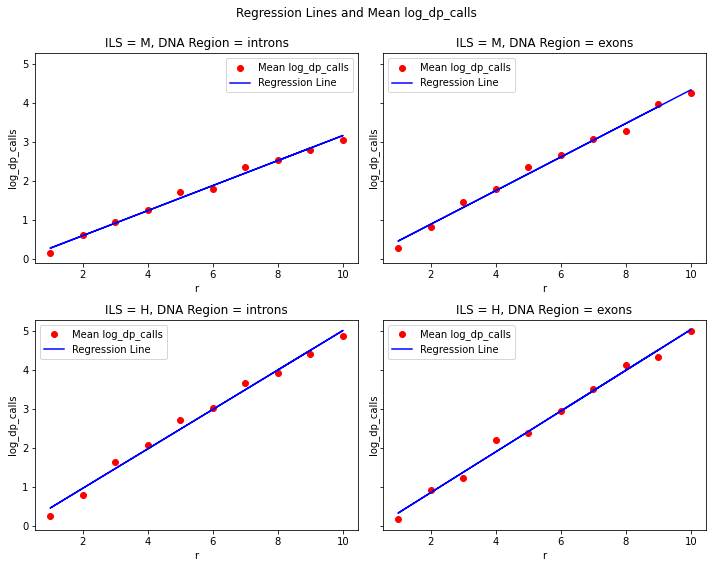

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)  # Share the Y-axis scale
fig.suptitle("Regression Lines and Mean log_dp_calls")

# Iterate through combinations and axes
for i, combo in enumerate(combinations):
    X, y, regression_model, result = perform_regression(result_df, combo[0], combo[1])
    ax = axes[i // 2, i % 2]  # Get the current subplot axis

    # Scatter plot the mean of log_dp_calls for each r
    mean_values = result_df[(result_df["ILS"] == combo[0]) & (result_df["dna region"] == combo[1])].groupby('r')['log_dp_calls'].mean()
    ax.scatter(mean_values.index, mean_values, label='Mean log_dp_calls', color='red')

    # Plot the regression line
    ax.plot(X.values, regression_model.predict(X), label='Regression Line', color='blue')  # Convert X to a NumPy array

    ax.set_title(f"ILS = {combo[0]}, DNA Region = {combo[1]}")
    ax.set_xlabel("r")
    ax.set_ylabel("log_dp_calls")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

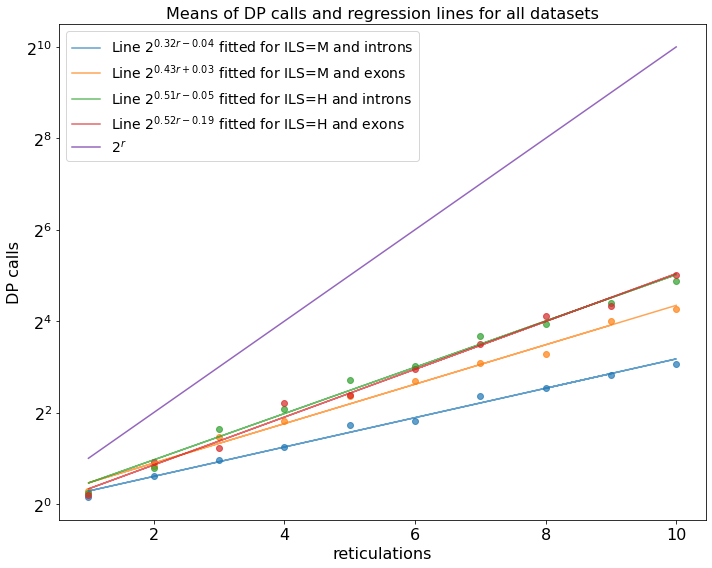

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def y_axis_formatter(x, pos):
    return f'$2^{{{x:.0f}}}$'

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Means of DP calls and regression lines for all datasets", fontsize=16)

# Iterate through combinations
for i, combo in enumerate(combinations):
    X, y, regression_model, result = perform_regression(result_df, combo[0], combo[1])
    coef = f"Slope: {result['slope']:.2f}, Intercept: {result['intercept']:.2f}, R-squared: {result['R-squared']:.2f}"

    # Scatter plot the mean of log_dp_calls for each r
    mean_values = result_df[(result_df["ILS"] == combo[0]) & (result_df["dna region"] == combo[1])].groupby('r')['log_dp_calls'].mean()
    ax.scatter(mean_values.index, mean_values, label=None, alpha=0.7)

    # Plot the regression line
    ax.plot(X.values, regression_model.predict(X), label=f"Line $2^{{{result['slope']:.2f}r{'+' if result['intercept']>0 else ''}{result['intercept']:.2f}}}$ fitted for ILS={combo[0]} and {combo[1]}", alpha=0.7)

lims = [1, 10]
ax.plot(lims, lims, label=r'$2^r$')
handles, labels = ax.get_legend_handles_labels()
ax.legend(prop={'size': 14})
ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))
ax.set_ylabel("DP calls", fontsize=16)
ax.set_xlabel("reticulations", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)  # Increase font size for tick labels


# Adjust layout
plt.tight_layout()
plt.savefig("plots/regression_lines.pdf", bbox_inches="tight", format="pdf")

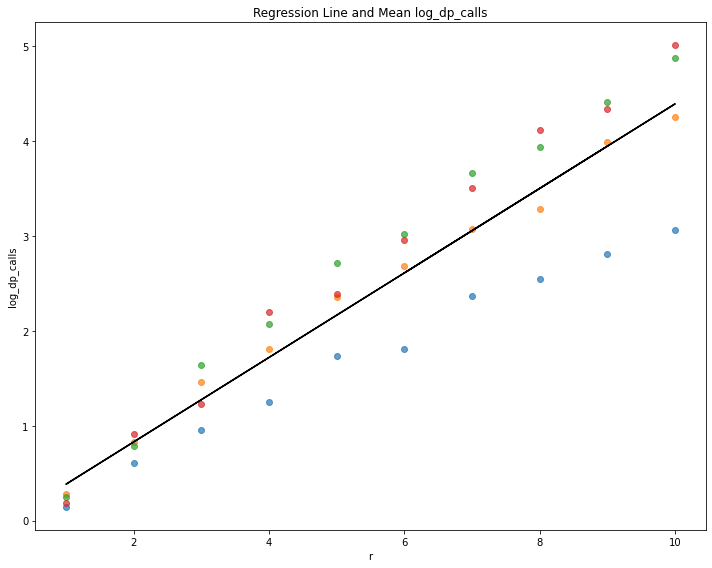

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Regression Line and Mean log_dp_calls")
ax.set_xlabel("r")
ax.set_ylabel("log_dp_calls")

# Collect all data points for plotting
all_X = []
all_y = []

# Iterate through combinations
for combo in combinations:
    X, y, _, _ = perform_regression(result_df, combo[0], combo[1])
    all_X.append(X)
    all_y.append(y)

# Concatenate all data points
all_X = np.concatenate(all_X)
all_y = np.concatenate(all_y)

# Fit a single regression line to all data points
model = LinearRegression()
model.fit(all_X, all_y)

# Scatter plot the mean of log_dp_calls for each r for each dataset
for i, combo in enumerate(combinations):
    X, y, _, _ = perform_regression(result_df, combo[0], combo[1])
    mean_y = y.groupby(X['r']).mean()
    ax.scatter(mean_y.index, mean_y, label=f"Mean log_dp_calls - ILS={combo[0]}, DNA Region={combo[1]}", alpha=0.7)

# Plot the single regression line
ax.plot(all_X, model.predict(all_X), label="Regression Line (All Datasets)", color='black')

# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
result_df.columns


Index(['Unnamed: 0', 'is_additional', 'dna region', 'ILS', 'n', 'r',
       'replicate', 'network', 'displayed_tree', 'gene tree',
       'gene_tree_inferred', 'gene_tree_rooted', 'is_correct', 'rf',
       'dp_called_fast_algo', 'branching_count_fast_algo',
       'max_depth_fast_algo', 'best_depth_fast_algo',
       'time_in_seconds_fast_algo', 'cost_fast_algo', 'time_naive',
       'cost_naive', 'log_dp_calls'],
      dtype='object')

In [18]:
result_df["DP_time_per_iteration"] = result_df["time_in_seconds_fast_algo"]/result_df["dp_called_fast_algo"]

In [19]:
result_df["naive_time_per_iteration"] = result_df["time_naive"]/(2**result_df["r"])

<AxesSubplot:xlabel='r', ylabel='naive_time_per_iteration'>

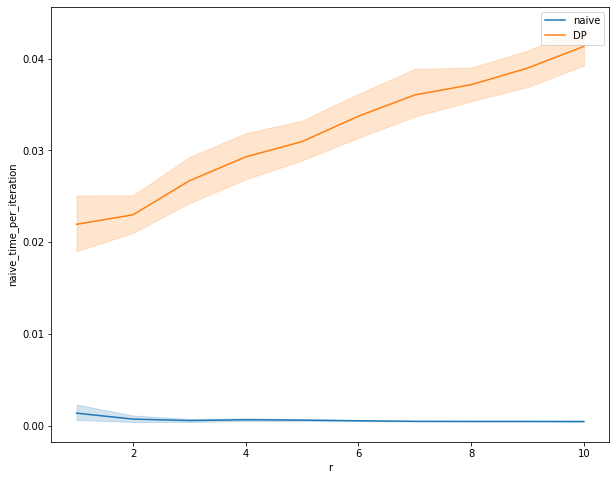

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=result_df, x="r", y="naive_time_per_iteration", ax=ax, label="naive")
sns.lineplot(data=result_df, x="r", y="DP_time_per_iteration", ax=ax, label="DP")

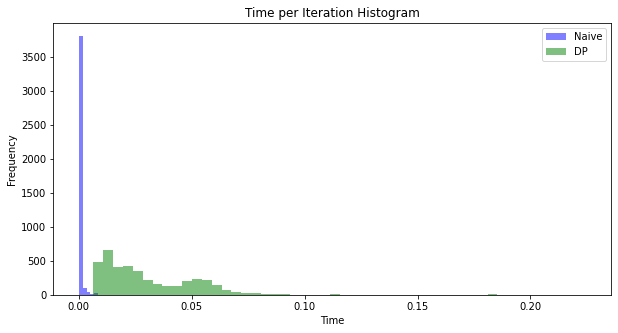

In [21]:
df = result_df

import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'df' with columns 'naive time per iteration' and 'DP time per iteration'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot histograms for 'naive time per iteration' and 'DP time per iteration' side by side
ax.hist(df['naive_time_per_iteration'], alpha=0.5, bins=50, label='Naive', color='blue')
ax.hist(df['DP_time_per_iteration'], alpha=0.5, bins=50, label='DP', color='green')

# Set labels and title
ax.set_title('Time per Iteration Histogram')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')

# Add a legend
ax.legend()
plt.show()






In [22]:
# Maybe just compute simple statistics like runtime per iteration, runtime: mean + sde?
